# Feature Engineering Using Spark SQL
Load data into Spark DataFrame, and create the features necessary for churn prediction

### Load libraries, files and prepare for processing

In [1]:
# Start a Spark session, in case not invoking from CMD as 'pyspark'
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Feature Engineering").getOrCreate()

In [2]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Load file
# Took 30 secs at least on 16GB 2015 Macbook Pro
df = spark.read.format('csv').options(header='true', inferSchema='true').load("../data/event_ds.csv").cache()
df

DataFrame[uid: int, event: string, song_id: double, date: timestamp]

In [4]:
# Confirm that we have day-level, time-stamped data of user activity
df.show()

+---------+-----+-----------+-------------------+
|      uid|event|    song_id|               date|
+---------+-----+-----------+-------------------+
|168540455|    P|   298250.0|2017-03-30 00:00:00|
|168550728|    P|   285233.0|2017-03-30 00:00:00|
|168551524|    P|  6635279.0|2017-03-30 00:00:00|
|168543348|    P|        0.0|2017-03-30 00:00:00|
|168550948|    P|   277286.0|2017-03-30 00:00:00|
|168548945|    P|2.0429929E7|2017-03-30 00:00:00|
|168550838|    P|    99018.0|2017-03-30 00:00:00|
|168549948|    P|2.3082492E7|2017-03-30 00:00:00|
|168547123|    P|        0.0|2017-03-30 00:00:00|
|168551442|    P|  1474915.0|2017-03-30 00:00:00|
|168543348|    P|        0.0|2017-03-30 00:00:00|
|168551311|    P|  7149583.0|2017-03-30 00:00:00|
|168551311|    P|  6359029.0|2017-03-30 00:00:00|
|168551311|    P|  6660691.0|2017-03-30 00:00:00|
|168550597|    P|   126530.0|2017-03-30 00:00:00|
|168543348|    P|        0.0|2017-03-30 00:00:00|
|168551524|    P|  6635281.0|2017-03-30 00:00:00|


In [5]:
# Cast 'date' column into 'date' type. Especially since we don't have hour-level data anyway!
df = df.withColumn('date', F.col('date').cast('date'))

# Confirm results of typecasting
df 

DataFrame[uid: int, event: string, song_id: double, date: date]

## Data Exploration

In [6]:
# Count number of events
# In the 10 millions!
df.count()

11523915

In [7]:
# Count distinct users --- match with notebook 3 confirmed
df.select('uid').distinct().count()

64527

In [8]:
# Count each type of events
# The vast majority are plays!
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  632820|
|    S|  791517|
|    P|10099578|
+-----+--------+



In [9]:
# First compute the relevant, then aggregate using max/min/mean etc
# Here we found the user who performed the most D/S/P events
# Not useful immediately, but potentially useful for studying behavior of 'most active users'
df.groupBy('event').agg(
    F.count(F.col('uid')).alias('count'),
    F.max(F.col('uid')).alias('max_uid')
).show()

+-----+--------+---------+
|event|   count|  max_uid|
+-----+--------+---------+
|    D|  632820|169246553|
|    S|  791517|169246553|
|    P|10099578|169251556|
+-----+--------+---------+



#### How does the amount of events changed as time progressed?

In [10]:
# Can use df.filter, in case we're interested in a restricted time frame
# df.filter((F.col('date')>='2017-04-01') & (F.col('date')<='2017-04-05')) \
#                     .groupBy('date','event').count() \
#                     .orderBy('date','event').show()

In [11]:
# But since we don't have much data, there'll be no filtering
date_count = df.groupBy('date').count().toPandas()

# Sort by date for easier reading and intuitive plotting
date_count = date_count.sort_values(by='date')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text xticklabel objects>)

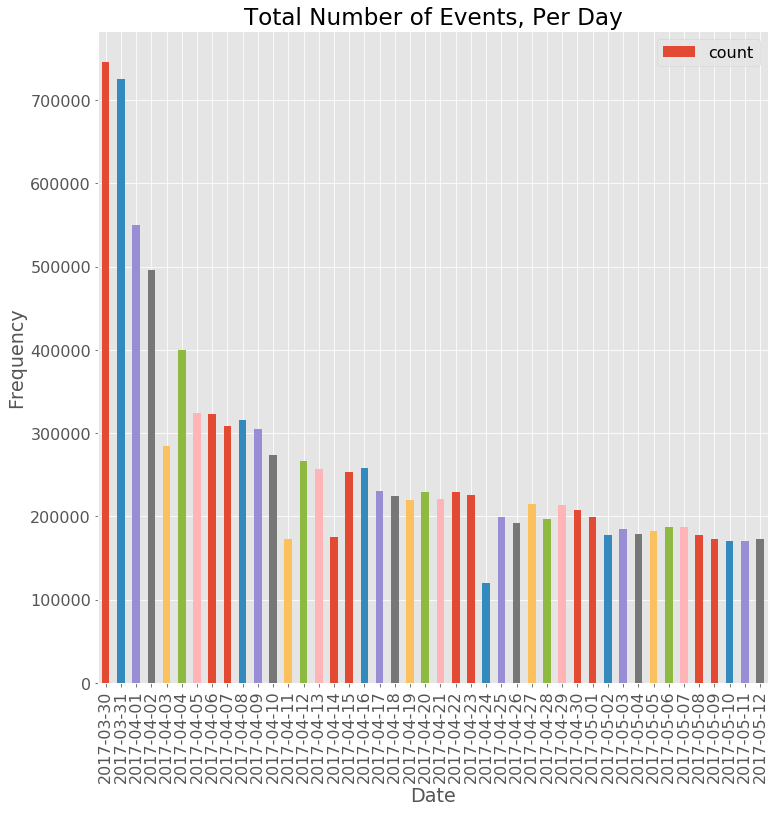

In [12]:
# Clear *global* decrease in the number of events, as time went on!!
# What could have gone wrong? Is there several churning? Must explore further

plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 16
date_count.plot.bar('date', 'count')

plt.title("Total Number of Events, Per Day")
plt.ylabel("Frequency")
plt.xlabel('Date')
plt.xticks(rotation='vertical')

#### See if the above trend differs among the 3 event types
In short, it **is** different. See eventual plot and comments below it for more details.

In [13]:
# Count events by type and date; must cache otherwise the operations that follow take forever
counts_by_event = df.groupBy(['event', 'date']).count().cache()

# Separate Pandas DF for each event
play_count = counts_by_event.filter(F.col('event') == 'P').toPandas()
download_count = counts_by_event.filter(F.col('event') == 'D').toPandas()
search_count = counts_by_event.filter(F.col('event') == 'S').toPandas()

# Sort date for eventual plotting
play_count.sort_values(by='date', inplace=True)
download_count.sort_values(by='date', inplace=True)
search_count.sort_values(by='date', inplace=True)

In [14]:
# Normalize by the amount on the first day
play_count['count'] = play_count['count'] / play_count['count'].iloc[0]
download_count['count'] = download_count['count'] / download_count['count'].iloc[0]
search_count['count'] = search_count['count'] / search_count['count'].iloc[0]

(array([736417., 736420., 736427., 736434., 736441., 736448., 736450.,
        736457.]), <a list of 8 Text xticklabel objects>)

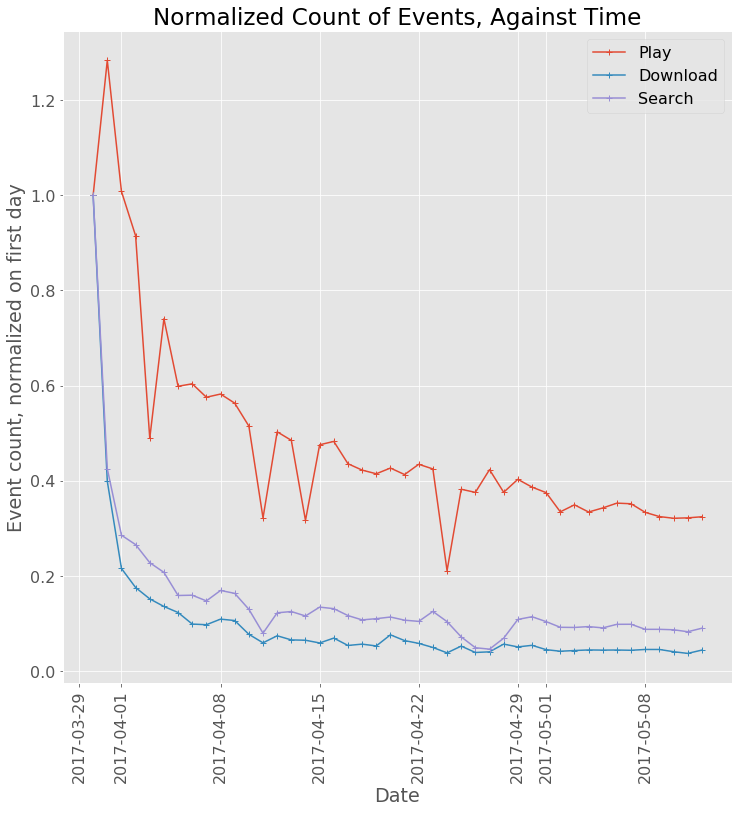

In [15]:
# Then plot!

fig, ax = plt.subplots()
play_count.plot(x='date', y='count', ax=ax, label="Play", style='-+')
download_count.plot(x='date', y='count', ax=ax, label="Download", style='-+')
search_count.plot(x='date', y='count', ax=ax, label="Search", style='-+')

ax.set_title("Normalized Count of Events, Against Time")
ax.set_ylabel("Event count, normalized on first day")
ax.set_xlabel("Date")
ax.legend()

plt.xticks(rotation='vertical')

#### Business observations from graph above
While all three events exhibit a simultaneous downwards trend *overall*, there are interesting exceptions on certain dates. For instance, see the dip in 'searches' right before 04-29; at the same time there was a small peak in 'plays'! Maybe this is not important in building a churn-prediction system, but it's worth investigating if one is to understand better the business performance of this streaming platform!

Concerning the significant dips in 'play': could there be a problem with the music player, or could there be load balancing issues for streaming? Given the limited data, we cannot investigate further; but those are the questions I would ask if I were at work.

All in all, once the reasons for churning are identified and the losses quantified, we can make informed decisions to mitigate further churning (e.g. by buying the right amount of hardware, not too much and not too little)

## Onwards to Model Building!
### Define Label (Churn / Not Churn)
We need to define "churning" --- i.e. when a user is considered as "inactive". Since we only have 6 weeks of data, we will go with the simple approach of
1. Model user acitivity on the first 4 weeks of data ('feature window')
2. Define 'churn' as the lack of activity in the last 2 weeks ('label window')

It is unacceptable to have a label window shorter than 2 weeks; after all, users may be preoccupied otherwise for a week or so, before returning to music streaming. But longer than a week? It is conceivable that they wouldn't come back. 

If there is sufficient data, we can actually *measure* the proportion of users who churned after two weeks of inactivity, and decide whether two weeks is a sufficiently long label window. (Definitely would try if this were to be a work project.)

In [16]:
# Verify the earliest and latest dates available
df.agg(F.min('date'), F.max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2017-03-30|2017-05-12|
+----------+----------+



In [17]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:',label_window_start_date,'~',label_window_end_date,'days:',label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date  - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,'~',feature_window_end_date,'days:',feature_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [18]:
# Collect all the uid's we will model; these are users with activity within the feature window
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))\
                    .select('uid').distinct()

# Did the above users churn in the label window? (churn/active: 1/0)
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) & (F.col('date')<=label_window_end_date))\
                            .select('uid').distinct().withColumn('label',F.lit(0))

In [19]:
# Prepare label data via SQL-joins (churn label=1; active label=0)
# Whichever user not in df_model_uid is considered churned
df_label = df_model_uid.join(df_active_uid_in_label_window, on=['uid'], how='left')
df_label = df_label.fillna(1)

In [20]:
# Finally, print distribution of 0/1 labels
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|39566|
|    0|23511|
+-----+-----+



### Feature generation
Here we create the features that describe user activity prior to churning (or not). 

In [21]:
# Collect acitivty data in the feature window
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))

In [22]:
'''
    Python list to capture all generated features
'''
df_feature_activity = []
df_feature_profile = []

#### Frequency features
The number of plays, downloads, and searches in the feature window

In [23]:
# Define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!

def frequency_feature_generation_time_windows(df, event, time_window_list, snapshot_date):
    """
        Generate frequency features for one event type and a list of time windows
    
        event: string 'S' 'P' or 'D'
        time_window_list: list of integers; e.g. [1, 4, 7] refers to 1, 4, 7 days before and including snapshot_date
        snapshot_date: Python date type
    """
    
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date),1).otherwise(0)).alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [24]:
''' 
    As a test: generate feature for 'P' event
    - Verified manually that for a user, that the feature is correct and valid
    - uid choice: max in play data (copied from cell above)
'''

event = 'P'
snapshot_date = feature_window_end_date
tmp_df = frequency_feature_generation_time_windows(df_feature_window, event, [1,3,5,30], snapshot_date)
tmp_df.persist()

# Print the newly generated feature for uid==168551430
# Number of plays: 179, for dates at least 5 days before feature_window_end_date
tmp_df.filter(F.col('uid')==169251556).show()

# Print the number of plays for uid==168551430 during the whole feature window; 53-8=45 indeed!
print( df_feature_window.filter( (F.col('uid')==169251556) & (F.col('event')=='P') \
                         & (F.col('date') <= (snapshot_date-datetime.timedelta(4))) ).count()
     )

# Delete the temporally generated DF
del tmp_df

+---------+-------------+-------------+-------------+--------------+
|      uid|freq_P_last_1|freq_P_last_3|freq_P_last_5|freq_P_last_30|
+---------+-------------+-------------+-------------+--------------+
|169251556|            0|            8|            8|            53|
+---------+-------------+-------------+-------------+--------------+

45


In [25]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date

for event in event_list:
    df_feature_activity.append(frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date))

In [26]:
df_feature_activity

[DataFrame[uid: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: int, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: int, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint]]

#### Recency features
The number of days between the last event in the feature window, and `label_window_start_date`

In [27]:
def recency_feature_generation_time_windows(df, event, snapshot_date):
    """
        Generate recency features for one event type and a list of time windows
                
        LOGIC: convert to UNIX timestamp, calculate time difference in secs, then divide by 86400 -> days
    
        df: Spark DataFrame containing data from feature window
        event: string 'S' 'P' or 'D'
        time_window_list: list of integers; e.g. [1, 4, 7] refers to 1, 4, 7 days before and including snapshot_date
        snapshot_date: Python date type
    """
    
    from time import mktime
        
    df_feature = df \
        .filter(F.col('event') == event) \
        .groupBy('uid') \
        .agg(( (mktime(snapshot_date.timetuple()) - F.unix_timestamp(F.max('date')))/86400 ).alias('recency_'+event))
    
    return df_feature

In [28]:
''' 
    As a test: generate feature for 'S' event
    - Verified manually that for a user, that the feature is correct and valid
    - uid choice: max in play data (copied from cell above)
'''

event = 'S'
snapshot_date = label_window_start_date
tmp_df = recency_feature_generation_time_windows(df_feature_window,event,snapshot_date)

# Print the newly generated feature for uid==169251556
tmp_df.filter(F.col('uid')==169246553).show()

# Print date of the latest search in feature window, for uid==169246553
# It is April 25 --- 4 days from label_window_start_date (April 29) indeed!
df_feature_window.filter( (F.col('uid')==169246553) \
                         & (F.col('event')=='S') \
                         & (F.col('date') <= snapshot_date)
                        ).agg(F.max('date')).show()

# Delete the temporally generated DF
del tmp_df

+---------+---------+
|      uid|recency_S|
+---------+---------+
|169246553|      4.0|
+---------+---------+

+----------+
| max(date)|
+----------+
|2017-04-25|
+----------+



In [29]:
# generate frequency features for all event_list, time_window_list
snapshot_date = label_window_start_date
event_list = ['P','D','S']
for event in event_list:
    df_feature_activity.append(recency_feature_generation_time_windows(df_feature_window,event,snapshot_date))

In [30]:
df_feature_activity

[DataFrame[uid: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: int, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: int, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint],
 DataFrame[uid: int, recency_P: double],
 DataFrame[uid: int, recency_D: double],
 DataFrame[uid: int, recency_S: double]]

### Profile features
Given the available data, 'profile' refers to the device (iOS/android) that generated logged events

In [31]:
# Load play records
df_play = spark.read.csv('../data/play_ds_cleaned.csv', header=True)
df_play.show(5)

+---------+------+---------+----------+---------+-----------+
|      uid|device|  song_id|      date|play_time|song_length|
+---------+------+---------+----------+---------+-----------+
|168540455|    ar| 298250.0|2017-03-30|    189.0|      190.0|
|168550728|    ar| 285233.0|2017-03-30|    282.0|      282.0|
|168551524|    ar|6635279.0|2017-03-30|      1.0|      231.0|
|168543348|    ar|      0.0|2017-03-30|     27.0|       63.0|
|168550948|    ar| 277286.0|2017-03-30|    254.0|      254.0|
+---------+------+---------+----------+---------+-----------+
only showing top 5 rows



In [32]:
# Filter down to obtain data in feature window
# Then, extract unique PAIRS of uid,device
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
df_device_tmp = df_play_feature_window.select('uid','device').distinct()

In [33]:
# Print the number of instances per device type
df_device_tmp.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    mc|    1|
|    ar|54925|
|    ip| 7965|
+------+-----+



In [34]:
# There ARE users who accessed the service with >1 devices
# df.select('uid').distinct().count() is 65417
print("Unique number of users: ", 65417)
print("Unique number of user/device pairs: ", df_device_tmp.distinct().count())

Unique number of users:  65417
Unique number of user/device pairs:  62891


In [35]:
# There aren't actually THAT many users who have played songs on multiple devices though!
# Explanaton of discrepancy: df_profile_tmp is built from play data only
# ...whereas df_label is built from the entire event set

multi_device_user = df_device_tmp.groupby('uid').count().filter(F.col('count') > 1)
multi_device_user.count()

13

In [36]:
# Encode device types into numbers. iOS == 1, android == 2
# There is a single instance of device 'mc', which we arbitarily grouped with 2

df_device_tmp = df_device_tmp.withColumn('device_type', \
                                           F.when(F.col('device')=='ip',1).otherwise(2))

# Should match with count from a few cells above
df_device_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 7965|
|          2|54926|
+-----------+-----+



In [37]:
# Build Spark DataFrame that matches label (from df_label) with device
# Only keep those uid's that have a label; hence left join

df_device = df_label.select('uid').join(df_device_tmp.select('uid','device_type'),on='uid',how='left')

In [38]:
# See above: null values in df_profile because of mismatches in uid
# Fill as '3', stand-in for 'unknown'
df_device = df_device.fillna({'device_type':3})

In [39]:
# Confirm that df_profile still records the multiple devices owned by certain users
df_device.groupBy('uid').count().filter(F.col('count') > 1).show()

# Print for a particular user just displayed
df_device.filter(F.col('uid')==168165762).show()

+---------+-----+
|      uid|count|
+---------+-----+
|168653359|    2|
|168165762|    2|
|169089329|    2|
|168576848|    2|
|  3647844|    2|
|168576854|    2|
|168577159|    2|
|168653255|    2|
|168651933|    2|
|168652896|    2|
|168653231|    2|
|168577178|    2|
|168652781|    2|
+---------+-----+

+---------+-----------+
|      uid|device_type|
+---------+-----------+
|168165762|          2|
|168165762|          1|
+---------+-----------+



In [40]:
# Finally, append device info to feature Python list
df_feature_profile.append(df_device)

### Total play time
The time (secs) that users have spent playing songs, in various time windows

In [41]:
# Cast to date type, for convenient windowing
df_play = df_play.withColumn('date', F.col('date').cast('date'))

# Cast to float type, as intended (e.g. see notebook 3.5)
df_play = df_play.withColumn('play_time', F.col('play_time').cast('float'))

In [42]:
# Can you generate total song play time features (using play_ds data) for different time window
# using play data (need to clean play time first, play time may be negative in data)
print("Number of df_play entries with negative play_time: ", \
      df_play.select('play_time').filter(F.col('play_time') < 0).count())

Number of df_play entries with negative play_time:  0


In [43]:
# Fix negative play_time by setting to 0 --- but none found
# i.e. Assume it's a system glitch --- songs weren't actually played
# df_play_tmp = df_play.withColumn('play_time', \
#                                  F.when(df_play['play_time']<0, 0).otherwise(df_play['play_time']))


In [44]:
df_play_tmp = df_play

In [45]:
def play_time_feature_generation_time_windows(df, time_window_list, snapshot_date):
    """
        Compute the total play time (secs) within a time window, before and including the snapshot date
        
        df: Spark DataFrame containing play data *only*
        time_window_list: list of integers; e.g. [1, 4, 7] refers to 1, 4, 7 days before and including snapshot_date
        snapshot_date: Python date type
    """
    
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum( \
                     F.when( (F.col('date') >= snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date), F.col('play_time')).otherwise(0))\
               .alias('play_time_last_'+str(time_window)) for time_window in time_window_list])
    
    return df_feature

In [46]:
df_play_tmp

DataFrame[uid: string, device: string, song_id: string, date: date, play_time: float, song_length: string]

In [47]:
df_play_tmp.agg(F.max('play_time')).show()

+--------------+
|max(play_time)|
+--------------+
|       65500.0|
+--------------+



In [48]:
# Generate play time features and append df_feature_activity
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_feature_activity.append(play_time_feature_generation_time_windows(df_play_tmp, time_window_list, snapshot_date))

### Fancier frequency features

In [49]:
# Can you generate counts of songs play 80% of their song length (using play_ds data) for different time window
# using play data (need to clean play time and song length first, 
# play time may be negative in data, song length may be zeros)

## Form Training Matrix and Save to File

In [50]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        df_master.persist() # uncomment if there are too many DFs to joins
    return df_master

In [51]:
# join all behavior features
df_model_final = join_feature_data(df_label, df_feature_activity)

In [52]:
df_model_final.columns

['uid',
 'label',
 'freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'recency_P',
 'recency_D',
 'recency_S',
 'play_time_last_1',
 'play_time_last_3',
 'play_time_last_7',
 'play_time_last_14',
 'play_time_last_30']

In [53]:
# join all profile features
df_model_final = join_feature_data(df_model_final, df_feature_profile)

In [54]:
df_model_final.fillna(0).toPandas().to_csv('../data/df_model_final.csv',index=False)